# Preliminary Classification Using Resampled Dataset
- Exactly the same code as the original nb06_extra2 except the order of train_test split
- train_test split first, train models on resampled train set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from matplotlib import cm

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
if True:
    from imblearn.under_sampling import TomekLinks, RandomUnderSampler
    from imblearn.over_sampling import SMOTE, ADASYN

In [3]:
if True:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, roc_curve, precision_recall_curve
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.svm import LinearSVC

In [4]:
# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

# Preprocess Majority

In [5]:
train = pd.read_csv('./train.csv')
bincat = pd.read_csv('./data/class_associated_bincat_features.csv')
ordinal = pd.read_csv('./data/class_associated_ordinal_features.csv')
data = pd.concat([bincat, ordinal, train.target], axis=1)

In [7]:
X = np.array(data.iloc[:, :-1])
y = np.array(data.iloc[:, -1])

In [8]:
%%time
tl = TomekLinks(n_jobs=8, ratio='majority')
X_tl, y_tl = tl.fit_sample(X, y)

print('Before tomek links: size of X: ', X.shape)
print('After  tomek links: size of X: ', X_tl.shape)
print('Before tomek links: class0/class1 = %d / %d' % (len(y)-np.sum(y), np.sum(y)))
print('After  tomek links: class0/class1 = %d / %d' % (len(y_tl)-np.sum(y_tl), np.sum(y_tl)))

Before tomek links: size of X:  (595212, 143)
After  tomek links: size of X:  (587821, 143)
Before tomek links: class0/class1 = 573518 / 21694
After  tomek links: class0/class1 = 566127 / 21694
CPU times: user 2h 28min 50s, sys: 2.36 s, total: 2h 28min 52s
Wall time: 19min 32s


# Undersampling class0 combined with oversampling of class1 by SMOTE

### Set up targets for number of samples for each class, resample training set

In [9]:
rstate = 55
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.3, random_state=rstate)

num_class1 = np.sum(y_train)
num_class1_to_resample = 3 * num_class1
num_class0_to_resample = int(1 * num_class1_to_resample)

# First, randomly undersample the majority
rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

# Then use SMOTE to oversample the minority
smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

print('Before Resampling: size of X: ', X_tl.shape)
print('After  Resampling: size of X: ', X_tlrus.shape)

print('Before Resampling: class0/class1 =%7d/%6d' % (len(y_train)-np.sum(y_train), np.sum(y_train)))
print('After  Resampling: class0/class1 =%7d/%6d' % (len(y_res)-np.sum(y_res), np.sum(y_res)))

Before Resampling: size of X:  (587821, 143)
After  Resampling: size of X:  (60740, 143)
Before Resampling: class0/class1 = 396289/ 15185
After  Resampling: class0/class1 =  45555/ 45555


### Run single round of classification with a set random_state for train_test split

======== Random Forest ========
             precision    recall  f1-score   support

          0     0.9670    0.8960    0.9302    169838
          1     0.0692    0.2017    0.1031      6509

avg / total     0.9338    0.8704    0.8996    176347

======== Gradient Boost ========
             precision    recall  f1-score   support

          0     0.9647    0.9742    0.9694    169838
          1     0.0951    0.0708    0.0812      6509

avg / total     0.9326    0.9408    0.9366    176347

CPU times: user 2min 8s, sys: 343 ms, total: 2min 8s
Wall time: 17.4 s


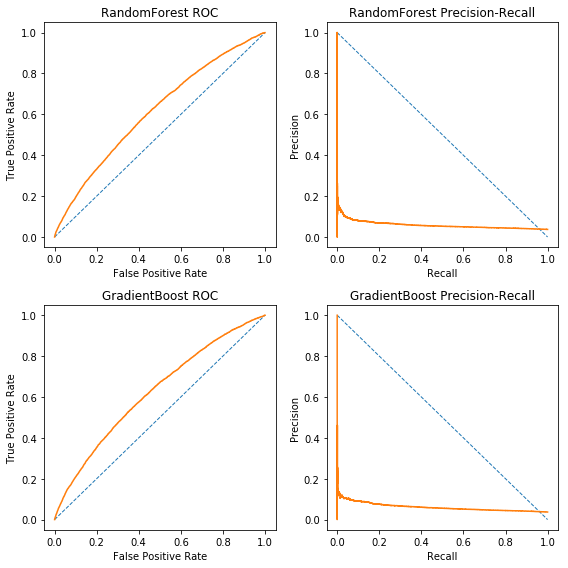

In [10]:
%%time
if True:
    
    fig = plt.figure(figsize=(8, 8))
    neutral_line = np.linspace(0, 1, 10)

    # RandomForest
    rfc = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
    rfc.fit(X_res, y_res)

    y_pred1 = rfc.predict(X_test)
    y_proba1 = rfc.predict_proba(X_test)
    report1 = classification_report(y_test, y_pred1, digits=4,
                                   labels=None, target_names=None)
    print('======== Random Forest ========')
    print(report1)

    precision1, recall1, _ = precision_recall_curve(y_test, y_proba1[:, 1], pos_label=1)
    fpr1, tpr1, _ = roc_curve(y_test, y_proba1[:, 1], pos_label=1)
    ax11 = fig.add_subplot(2, 2, 1)
    ax12 = fig.add_subplot(2, 2, 2)
    ax11.plot(neutral_line, neutral_line, lw=1, ls='--')
    ax11.plot(fpr1, tpr1)
    ax11.set_xlabel('False Positive Rate')
    ax11.set_ylabel('True Positive Rate')
    ax11.set_title('RandomForest ROC')
    ax12.plot(neutral_line, 1- neutral_line, lw=1, ls='--')
    ax12.plot(recall1, precision1)
    ax12.set_xlabel('Recall')
    ax12.set_ylabel('Precision')
    ax12.set_title('RandomForest Precision-Recall')

    # GradientBoost
    clf = XGBClassifier(max_depth=10, n_estimators=100, n_jobs=8)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)
    print('======== Gradient Boost ========')
    print(report2)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21 = fig.add_subplot(2, 2, 3)
    ax22 = fig.add_subplot(2, 2, 4)
    ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

    plt.tight_layout()

### Run classification multiple rounds with random train_test splitting (try 10 times)

RFC Mean Gini: 0.256+/-0.000, Best=0.256
XGB Mean Gini: 0.280+/-0.000, Best=0.280
CPU times: user 1min 41s, sys: 430 ms, total: 1min 42s
Wall time: 17 s


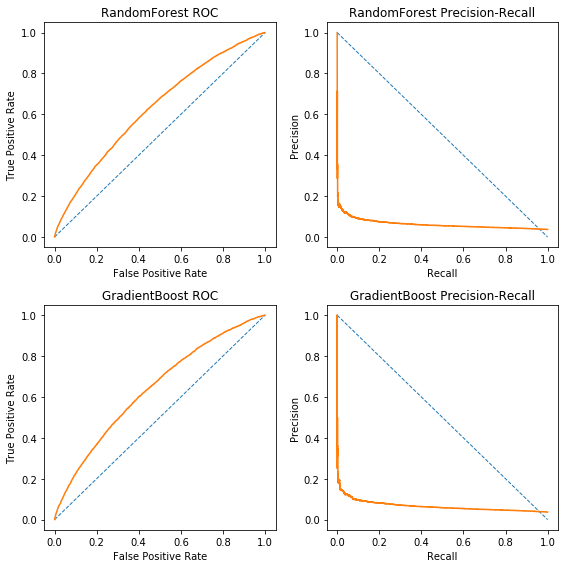

In [11]:
%%time
fig = plt.figure(figsize=(8, 8))
ax11 = fig.add_subplot(2, 2, 1)
ax12 = fig.add_subplot(2, 2, 2)
ax21 = fig.add_subplot(2, 2, 3)
ax22 = fig.add_subplot(2, 2, 4)

neutral_line = np.linspace(0, 1, 10)
ax11.plot(neutral_line, neutral_line, lw=1, ls='--')
ax12.plot(neutral_line, 1- neutral_line, lw=1, ls='--')
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_rfc = []
ginis_xgb = []

for i in range(1):
    
    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.3, random_state=rstate)
    
    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)
                                                        
    # RandomForest
    rfc = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
    rfc.fit(X_res, y_res)

    y_pred1 = rfc.predict(X_test)
    y_proba1 = rfc.predict_proba(X_test)
    ginis_rfc.append(eval_gini(y_test, y_proba1[:, 1]))
    report1 = classification_report(y_test, y_pred1, digits=4,
                                   labels=None, target_names=None)

    precision1, recall1, _ = precision_recall_curve(y_test, y_proba1[:, 1], pos_label=1)
    fpr1, tpr1, _ = roc_curve(y_test, y_proba1[:, 1], pos_label=1)
    ax11.plot(fpr1, tpr1)
    ax11.set_xlabel('False Positive Rate')
    ax11.set_ylabel('True Positive Rate')
    ax11.set_title('RandomForest ROC')
    ax12.plot(recall1, precision1)
    ax12.set_xlabel('Recall')
    ax12.set_ylabel('Precision')
    ax12.set_title('RandomForest Precision-Recall')

    # GradientBoost
    clf = XGBClassifier(alpha=8, max_depth=5, n_estimators=200, n_jobs=8)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(eval_gini(y_test, y_proba2[:, 1]))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

    # Naive Bayes
    nb = MultinomialNB()
    nb.fit(X_train, y_train)

    y_pred3 = nb.predict(X_test)
    y_proba3 = nb.predict_proba(X_test)
    report3 = classification_report(y_test, y_pred3, digits=4,
                                   labels=None, target_names=None)

plt.tight_layout()

print('RFC Mean Gini: %.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_rfc), np.std(ginis_rfc), np.max(ginis_rfc)))
print('XGB Mean Gini: %.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

- All the models are not really dependent on the train_test splits.
- RandomForest and GradientBoost appear most promising

## Conclusion
- Trained model doesn't work so well with the imbalanced set...
- May need to approach differently

## Tuning XGBoost

In [12]:
from sklearn.metrics import make_scorer
ginig_scorer = make_scorer(eval_gini, needs_proba=True)

In [13]:
rstate = None
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.3, random_state=rstate)

num_class1 = np.sum(y_train)
num_class1_to_resample = 2 * num_class1
num_class0_to_resample = int(1 * num_class1_to_resample)

# First, randomly undersample the majority
rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

# Then use SMOTE to oversample the minority
smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

In [14]:
%%time
xgb = XGBClassifier(n_estimators=200, n_jobs=8)
parameters = {'gamma':[1, 5, 10], 'max_depth':[5, 6, 7], 'reg_alpha':[0, 3, 5, 8],
              'reg_lambda':[0, 1, 3, 5]}
clf = GridSearchCV(xgb, parameters, scoring='f1', verbose=3)
clf.fit(X_res, y_res)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] gamma=1, max_depth=5, reg_alpha=0, reg_lambda=0 .................
[CV]  gamma=1, max_depth=5, reg_alpha=0, reg_lambda=0, score=0.062470240929435296, total=   5.7s
[CV] gamma=1, max_depth=5, reg_alpha=0, reg_lambda=0 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV]  gamma=1, max_depth=5, reg_alpha=0, reg_lambda=0, score=0.702948120346268, total=   5.5s
[CV] gamma=1, max_depth=5, reg_alpha=0, reg_lambda=0 .................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s


[CV]  gamma=1, max_depth=5, reg_alpha=0, reg_lambda=0, score=0.9025985663082438, total=   5.4s
[CV] gamma=1, max_depth=5, reg_alpha=0, reg_lambda=1 .................
[CV]  gamma=1, max_depth=5, reg_alpha=0, reg_lambda=1, score=0.059935102118724944, total=   5.7s
[CV] gamma=1, max_depth=5, reg_alpha=0, reg_lambda=1 .................
[CV]  gamma=1, max_depth=5, reg_alpha=0, reg_lambda=1, score=0.7029385034837927, total=   5.6s
[CV] gamma=1, max_depth=5, reg_alpha=0, reg_lambda=1 .................
[CV]  gamma=1, max_depth=5, reg_alpha=0, reg_lambda=1, score=0.9033820758948596, total=   5.4s
[CV] gamma=1, max_depth=5, reg_alpha=0, reg_lambda=3 .................
[CV]  gamma=1, max_depth=5, reg_alpha=0, reg_lambda=3, score=0.06273238630946706, total=   5.7s
[CV] gamma=1, max_depth=5, reg_alpha=0, reg_lambda=3 .................
[CV]  gamma=1, max_depth=5, reg_alpha=0, reg_lambda=3, score=0.7013930950938825, total=   5.5s
[CV] gamma=1, max_depth=5, reg_alpha=0, reg_lambda=3 .................
[

[CV]  gamma=1, max_depth=6, reg_alpha=0, reg_lambda=1, score=0.7041423675825167, total=   6.4s
[CV] gamma=1, max_depth=6, reg_alpha=0, reg_lambda=1 .................
[CV]  gamma=1, max_depth=6, reg_alpha=0, reg_lambda=1, score=0.902099467299342, total=   6.4s
[CV] gamma=1, max_depth=6, reg_alpha=0, reg_lambda=3 .................
[CV]  gamma=1, max_depth=6, reg_alpha=0, reg_lambda=3, score=0.07332514409902674, total=   6.7s
[CV] gamma=1, max_depth=6, reg_alpha=0, reg_lambda=3 .................
[CV]  gamma=1, max_depth=6, reg_alpha=0, reg_lambda=3, score=0.7033561891014074, total=   6.5s
[CV] gamma=1, max_depth=6, reg_alpha=0, reg_lambda=3 .................
[CV]  gamma=1, max_depth=6, reg_alpha=0, reg_lambda=3, score=0.9000133970437191, total=   6.3s
[CV] gamma=1, max_depth=6, reg_alpha=0, reg_lambda=5 .................
[CV]  gamma=1, max_depth=6, reg_alpha=0, reg_lambda=5, score=0.07098911500236631, total=   6.7s
[CV] gamma=1, max_depth=6, reg_alpha=0, reg_lambda=5 .................
[CV

[CV]  gamma=1, max_depth=7, reg_alpha=0, reg_lambda=3, score=0.08060879368658398, total=   8.4s
[CV] gamma=1, max_depth=7, reg_alpha=0, reg_lambda=3 .................
[CV]  gamma=1, max_depth=7, reg_alpha=0, reg_lambda=3, score=0.7069212410501192, total=   8.1s
[CV] gamma=1, max_depth=7, reg_alpha=0, reg_lambda=3 .................
[CV]  gamma=1, max_depth=7, reg_alpha=0, reg_lambda=3, score=0.900093787682551, total=   7.7s
[CV] gamma=1, max_depth=7, reg_alpha=0, reg_lambda=5 .................
[CV]  gamma=1, max_depth=7, reg_alpha=0, reg_lambda=5, score=0.08202721726888786, total=   8.3s
[CV] gamma=1, max_depth=7, reg_alpha=0, reg_lambda=5 .................
[CV]  gamma=1, max_depth=7, reg_alpha=0, reg_lambda=5, score=0.704955223880597, total=   7.9s
[CV] gamma=1, max_depth=7, reg_alpha=0, reg_lambda=5 .................
[CV]  gamma=1, max_depth=7, reg_alpha=0, reg_lambda=5, score=0.8991701615062014, total=   7.8s
[CV] gamma=1, max_depth=7, reg_alpha=3, reg_lambda=0 .................
[CV]

[CV]  gamma=5, max_depth=5, reg_alpha=0, reg_lambda=3, score=0.9035327916685371, total=   9.5s
[CV] gamma=5, max_depth=5, reg_alpha=0, reg_lambda=5 .................
[CV]  gamma=5, max_depth=5, reg_alpha=0, reg_lambda=5, score=0.0499567681813815, total=   5.6s
[CV] gamma=5, max_depth=5, reg_alpha=0, reg_lambda=5 .................
[CV]  gamma=5, max_depth=5, reg_alpha=0, reg_lambda=5, score=0.7023643104600984, total=   5.4s
[CV] gamma=5, max_depth=5, reg_alpha=0, reg_lambda=5 .................
[CV]  gamma=5, max_depth=5, reg_alpha=0, reg_lambda=5, score=0.8979938340556721, total=   7.2s
[CV] gamma=5, max_depth=5, reg_alpha=3, reg_lambda=0 .................
[CV]  gamma=5, max_depth=5, reg_alpha=3, reg_lambda=0, score=0.045722002507957944, total=   5.7s
[CV] gamma=5, max_depth=5, reg_alpha=3, reg_lambda=0 .................
[CV]  gamma=5, max_depth=5, reg_alpha=3, reg_lambda=0, score=0.7036273201504306, total=  11.5s
[CV] gamma=5, max_depth=5, reg_alpha=3, reg_lambda=0 .................
[C

KeyboardInterrupt: 

In [15]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score')

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [ ]:
clf.best_estimator_

In [ ]:
%%time
best = clf.best_estimator_
best.fit(X_res, y_res)

y_pred2 = best.predict(X_test)
y_proba2 = best.predict_proba(X_test)
gini_score = eval_gini(y_test, y_proba2[:, 1])
report2 = classification_report(y_test, y_pred2, digits=4,
                               labels=None, target_names=None)
print(report2)
print('gini = %.4f' % gini_score)
precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)

fig, (ax21, ax22) = plt.subplots(1, 2, figsize=(10, 5))
ax21.plot(fpr2, tpr2)
ax21.set_xlabel('False Positive Rate')
ax21.set_ylabel('True Positive Rate')
ax21.set_title('GradientBoost ROC')
ax22.plot(recall2, precision2)
ax22.set_xlabel('Recall')
ax22.set_ylabel('Precision')
ax22.set_title('GradientBoost Precision-Recall')

In [16]:
%%time
xgb = XGBClassifier(n_estimators=200, n_jobs=8)
parameters = {'gamma':[0.1, 1], 'max_depth':[7, 8], 'colsample_bytree':[0.5, .8]}
clf2 = GridSearchCV(xgb, parameters, scoring='f1', verbose=2, n_jobs=1)
clf2.fit(X_res, y_res)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] colsample_bytree=0.5, gamma=0.1, max_depth=7 ....................
[CV] ..... colsample_bytree=0.5, gamma=0.1, max_depth=7, total=   5.1s
[CV] colsample_bytree=0.5, gamma=0.1, max_depth=7 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] ..... colsample_bytree=0.5, gamma=0.1, max_depth=7, total=   4.5s
[CV] colsample_bytree=0.5, gamma=0.1, max_depth=7 ....................
[CV] ..... colsample_bytree=0.5, gamma=0.1, max_depth=7, total=   4.4s
[CV] colsample_bytree=0.5, gamma=0.1, max_depth=8 ....................
[CV] ..... colsample_bytree=0.5, gamma=0.1, max_depth=8, total=   5.6s
[CV] colsample_bytree=0.5, gamma=0.1, max_depth=8 ....................
[CV] ..... colsample_bytree=0.5, gamma=0.1, max_depth=8, total=   5.3s
[CV] colsample_bytree=0.5, gamma=0.1, max_depth=8 ....................
[CV] ..... colsample_bytree=0.5, gamma=0.1, max_depth=8, total=   6.0s
[CV] colsample_bytree=0.5, gamma=1, max_depth=7 ......................
[CV] ....... colsample_bytree=0.5, gamma=1, max_depth=7, total=   5.8s
[CV] colsample_bytree=0.5, gamma=1, max_depth=7 ......................
[CV] ....... colsample_bytree=0.5, gamma=1, max_depth=7, total=   4.8s
[CV] colsample_bytree=0.5, gamma=1, max_depth=7 ......................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  2.6min finished


CPU times: user 20min 34s, sys: 935 ms, total: 20min 35s
Wall time: 2min 42s


In [17]:
clf2.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=8, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

             precision    recall  f1-score   support

          0     0.9667    0.9245    0.9451    169776
          1     0.0829    0.1762    0.1128      6571

avg / total     0.9337    0.8967    0.9141    176347

gini = 0.2705
CPU times: user 1min 6s, sys: 118 ms, total: 1min 6s
Wall time: 9.08 s


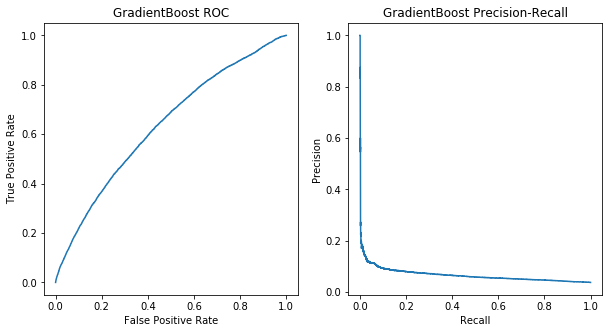

In [19]:
%%time
best2 = clf2.best_estimator_
best2.fit(X_res, y_res)

y_pred2 = best2.predict(X_test)
y_proba2 = best2.predict_proba(X_test)
gini_score = eval_gini(y_test, y_proba2[:, 1])
report2 = classification_report(y_test, y_pred2, digits=4,
                               labels=None, target_names=None)
print(report2)
print('gini = %.4f' % gini_score)
precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)

fig, (ax21, ax22) = plt.subplots(1, 2, figsize=(10, 5))
ax21.plot(fpr2, tpr2)
ax21.set_xlabel('False Positive Rate')
ax21.set_ylabel('True Positive Rate')
ax21.set_title('GradientBoost ROC')
ax22.plot(recall2, precision2)
ax22.set_xlabel('Recall')
ax22.set_ylabel('Precision')
ax22.set_title('GradientBoost Precision-Recall')